In [2]:
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import py3Dmol
from DSSPparser import parseDSSP

In [3]:
CAMEO_PREDICTION_PATH = "../data/taccruns/predictions-cameo/"
CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0/"
DSSP_PATH = "../data/taccruns/DSSP/"
FASTA_DIR = "../data/taccruns/fasta_dir/"

In [23]:
def tmscore(target, modified):
    tmscore = -1
    os.system(f"./../tmscore/TMscore {target} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore
def get_amino_acid_len(protien):
    with open(FASTA_DIR + protien + '.fasta') as f:
        fastafile = f.readlines()
    return(len(fastafile[1]))
def get_max_atom_distance(pth):
    max_dist = -1
    list_atom_locs = []
    with open(pth) as p:
        content = p.readlines()
    for line in content:
        if line.startswith("ATOM"):
            line = line.replace('-', ' -') # this is important for when two numbers are too close that there is not a space between
            list_atom_locs.append([float(line.split()[6]),float(line.split()[7]),float(line.split()[8])])
            if line.split()[9] != "1.00":
                print(pth)
                print('WARNING: ATOM LOCATION FAILED. SEE get_max_atom_distance')
    points = np.array(list_atom_locs)
    hull = ConvexHull(points)
    hullpoints = points[hull.vertices,:]
    hdist = cdist(hullpoints, hullpoints, metric='euclidean')
    bestpair = np.unravel_index(hdist.argmax(), hdist.shape)
    return distance.euclidean( hullpoints[bestpair[0]], hullpoints[bestpair[1]] )
def get_secondary_struc_data(pth):
    H = 0# H         Alpha helix (4-12)
    B = 0# B         Isolated beta-bridge residue
    E = 0# E         Strand
    G = 0# G         3-10 helix
    I = 0# I         Pi helix
    T = 0# T         Turn
    S = 0# S         Bend
    n = 0# -         None
    parser = parseDSSP(pth)
    parser.parse()
    pddict = parser.dictTodataframe()
    for line in pddict['struct']:
        if line.strip() == 'H': H+=1
        if line.strip() == 'B': B+=1
        if line.strip() == 'E': E+=1
        if line.strip() == 'G': G+=1
        if line.strip() == 'I': I+=1
        if line.strip() == 'T': T+=1
        if line.strip() == 'S': S+=1
        if line.strip() == '': n+=1
    return H, B, E, G, I, T, S, n
print(get_secondary_struc_data(DSSP_PATH + '6tf4_A_model_1_ptm_unrelaxed.pdb' + '.dssp'))
print(get_max_atom_distance(CAMEO_PREDICTION_PATH + '7tav_B_model_1_ptm_unrelaxed.pdb'))
print(tmscore(CAMEO_PREDICTION_PATH + '7tav_B_model_1_ptm_unrelaxed.pdb', CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + '7tav_B_model_1_ptm_unrelaxed.pdb'))
print(get_amino_acid_len('7rdt_A'))

(8, 0, 30, 3, 0, 9, 5, 12)
70.40555799793083
0.9971
250


In [24]:
hmmstats_dict = {}
with open(CAMEO_PREDICTION_PATH + "hmmstat.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]] = {}
    hmmstats_dict[parsed[0]]['n'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['effn'] = float(parsed[5])
    hmmstats_dict[parsed[0]]['M'] = float(parsed[6])
    hmmstats_dict[parsed[0]]['relent'] = float(parsed[7])
    hmmstats_dict[parsed[0]]['info'] = float(parsed[8])
    hmmstats_dict[parsed[0]]['prelE'] = float(parsed[9])
    hmmstats_dict[parsed[0]]['compkl'] = float(parsed[10])
with open(CAMEO_PREDICTION_PATH + "MSV_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['MSV1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['MSV2'] = float(parsed[5])
with open(CAMEO_PREDICTION_PATH + "VITERBI_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['VITERBI1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['VITERBI2'] = float(parsed[5])
with open(CAMEO_PREDICTION_PATH + "FORWARD_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['FORWARD1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['FORWARD2'] = float(parsed[5])
hmmvals = ['n','effn','M','relent','info','prelE','compkl','MSV1','MSV2','VITERBI1','VITERBI2','FORWARD1','FORWARD2']

In [25]:
cameo_dict = {}
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH): #for each predicted structure
    if pdb_file[-1] == "b": #check if is a pdb file
        if pdb_file[19:26] == 'unrelax': #check if it the unrelaxed prediction
            protein = pdb_file[0:6]
            cameo_dict[protein] = {}
            cameo_dict[protein]['tmscore'] = tmscore(CAMEO_PREDICTION_PATH + pdb_file, CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + pdb_file)
            for stat in hmmvals:
                cameo_dict[protein][stat] = hmmstats_dict[protein][stat]
            cameo_dict[protein]['seqlen'] = get_amino_acid_len(protein)
            cameo_dict[protein]['folded_size'] = get_max_atom_distance(CAMEO_PREDICTION_PATH + pdb_file)
            cameo_dict[protein]['compactness'] = cameo_dict[protein]['folded_size']/cameo_dict[protein]['seqlen']
            
            Alphahelix412, Isolatedbetabridgeresidue, Strand, helix310, Pihelix, Turn, Bend, no_code = get_secondary_struc_data(DSSP_PATH + pdb_file + '.dssp')
            cameo_dict[protein]['Alphahelix412'] = Alphahelix412
            cameo_dict[protein]['Isolatedbetabridgeresidue'] = Isolatedbetabridgeresidue
            cameo_dict[protein]['Strand'] = Strand
            cameo_dict[protein]['helix310'] = helix310
            cameo_dict[protein]['Pihelix'] = Pihelix
            cameo_dict[protein]['Turn'] = Turn
            cameo_dict[protein]['Bend'] = Bend
            cameo_dict[protein]['no_code'] = no_code
            cameo_dict[protein]['helix'] = Alphahelix412 + helix310
            cameo_dict[protein]['coil'] = no_code + Pihelix + Turn + Bend
            cameo_dict[protein]['extended'] = Isolatedbetabridgeresidue + Strand

stats = list(cameo_dict['6tf4_A'].keys())
stats.remove('tmscore')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


list tmscore < 0.4
protein ['n', 'effn', 'M', 'relent', 'info', 'prelE', 'compkl', 'MSV1', 'MSV2', 'VITERBI1', 'VITERBI2', 'FORWARD1', 'FORWARD2', 'seqlen', 'folded_size', 'compactness', 'Alphahelix412', 'Isolatedbetabridgeresidue', 'Strand', 'helix310', 'Pihelix', 'Turn', 'Bend', 'no_code', 'helix', 'coil', 'extended']
7b26_C [0.2948, 145.0, 3.67, 181.0, 0.59, 0.52, 0.51, 0.06, -10.6421, 0.70663, -11.5645, 0.70663, -4.725, 0.70663, 180, 83.87955210300065, 0.4659975116833369, 18, 2, 74, 0, 0, 16, 16, 54, 18, 86, 76]
7e2v_A [0.3534, 10000.0, 8.54, 547.0, 0.59, 0.57, 0.52, 0.01, -12.0496, 0.69761, -12.7737, 0.69761, -6.1657, 0.69761, 550, 114.93994747693249, 0.2089817226853318, 173, 2, 112, 53, 0, 60, 39, 111, 226, 210, 114]
6xqj_A [0.4271, 4272.0, 6.97, 234.0, 0.59, 0.58, 0.53, 0.03, -10.9263, 0.70358, -11.5772, 0.70358, -5.0157, 0.70358, 234, 79.37586039218725, 0.33921307859909083, 138, 0, 0, 10, 0, 8, 8, 70, 148, 86, 0]
7kdx_B [0.4029, 10000.0, 60.01, 681.0, 0.59, 0.57, 0.51, 0.01, -1

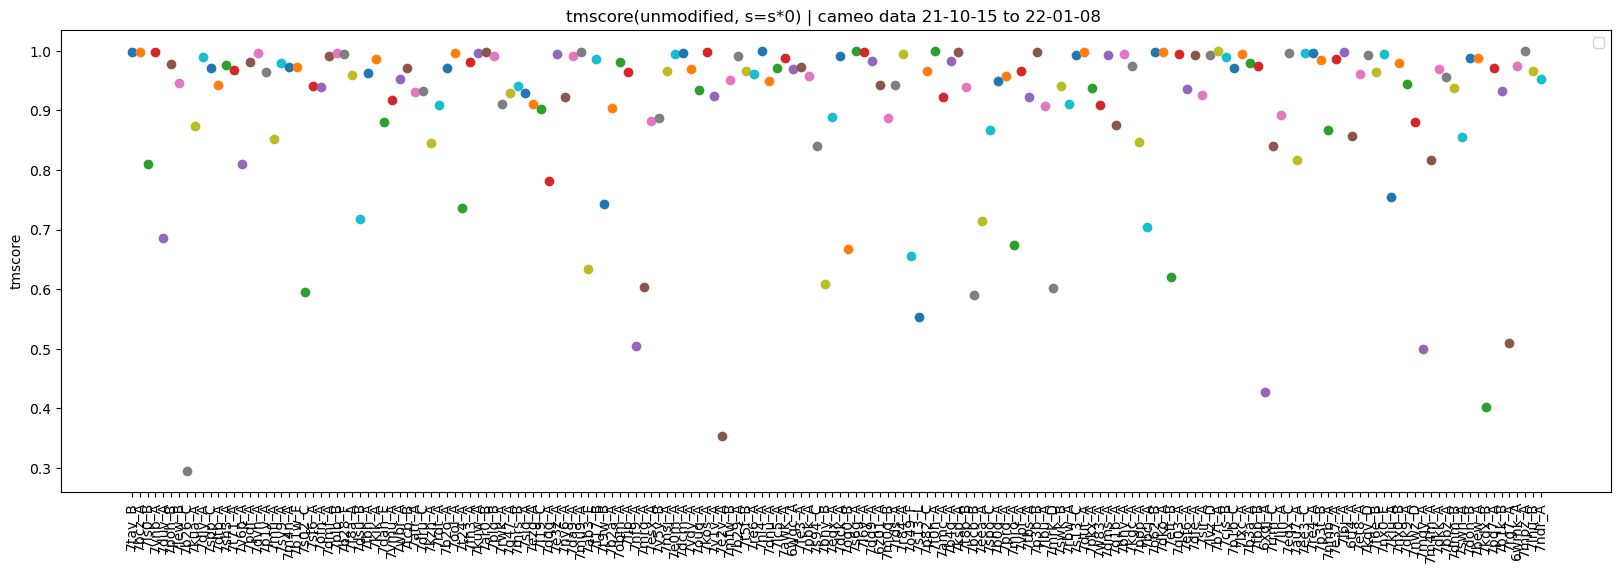

In [26]:
print('list tmscore < 0.4')
print('protein', stats)
plt.rcParams['figure.figsize'] = [20, 6]
for protein in cameo_dict.keys():
    plt.scatter(protein, cameo_dict[protein]['tmscore'])
    if cameo_dict[protein]['tmscore'] < 0.5:
        print(protein, list(cameo_dict[protein].values()))
plt.legend()
plt.ylabel('tmscore')
plt.title('tmscore(unmodified, s=s*0) | cameo data 21-10-15 to 22-01-08 ')
plt.xticks(rotation=90)
plt.show()

In [27]:
exclude = []#['7kdx_B'] # this outlier has an effn=60
list_stats_r2 = {}
for stat in stats:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            x.append(cameo_dict[protein][stat])
            y.append(cameo_dict[protein]['tmscore'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    list_stats_r2[stat] = r_value**2

for w in sorted(list_stats_r2, key=list_stats_r2.get, reverse=True):
    print(w, list_stats_r2[w])
# MSV: multi-segment Viterbi
# VITERBI: optimal alignment score
# FORWARD: The full likelihood of the profile/sequence 
#          comparison is evaluated, summed over the entire 
#          alignment ensemble, using the HMM Forward algorithm

folded_size 0.20281493124540678
effn 0.08552750259841278
no_code 0.08349080932699242
coil 0.038874336712604006
compactness 0.028926000244119
extended 0.021965177350934006
Strand 0.02181571861815398
seqlen 0.018691560265379745
M 0.0172851215766874
MSV1 0.01477491157934305
Turn 0.007864912268933282
VITERBI1 0.007688212689606268
Bend 0.006465494901714338
Isolatedbetabridgeresidue 0.005981923812638403
Pihelix 0.00362221997477932
helix310 0.0028323339431113505
MSV2 0.0022912666703699485
VITERBI2 0.0022912666703699485
FORWARD2 0.0022912666703699485
FORWARD1 0.0017566874991450684
relent 0.0006488626911037858
prelE 0.0002912751706128378
Alphahelix412 0.00020817993530097479
info 0.00017790738986396006
compkl 0.0001705304851886188
n 6.391437689458284e-05
helix 5.030725114057452e-05


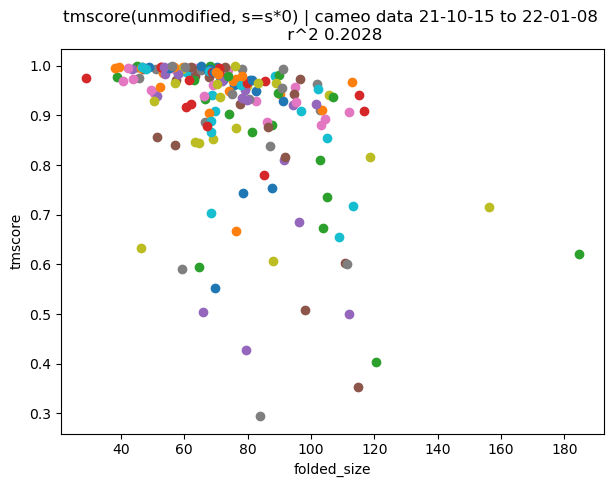

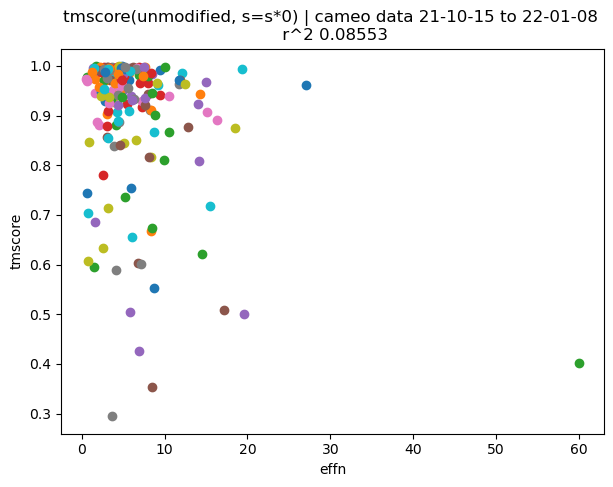

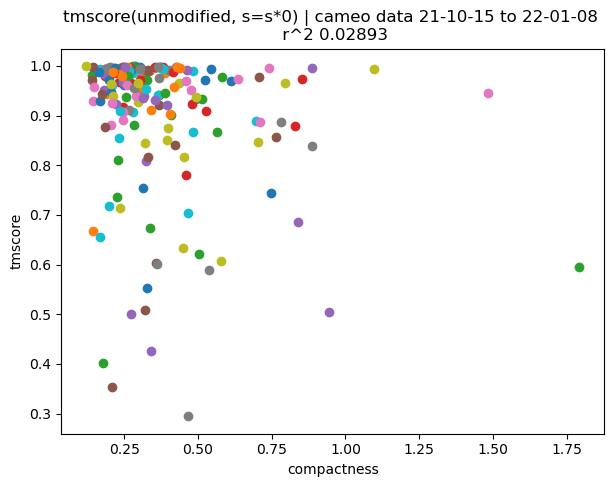

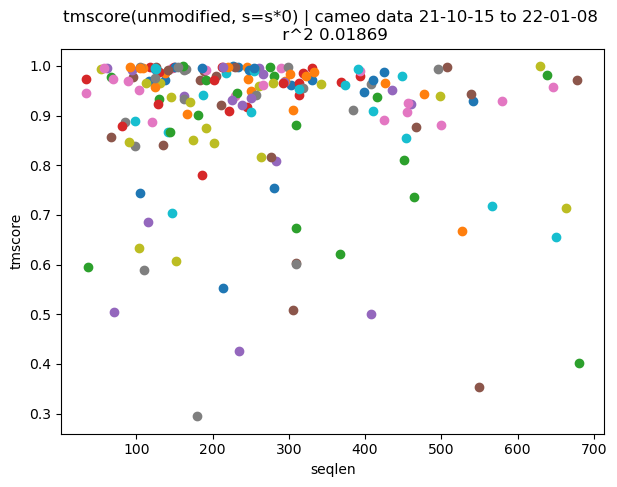

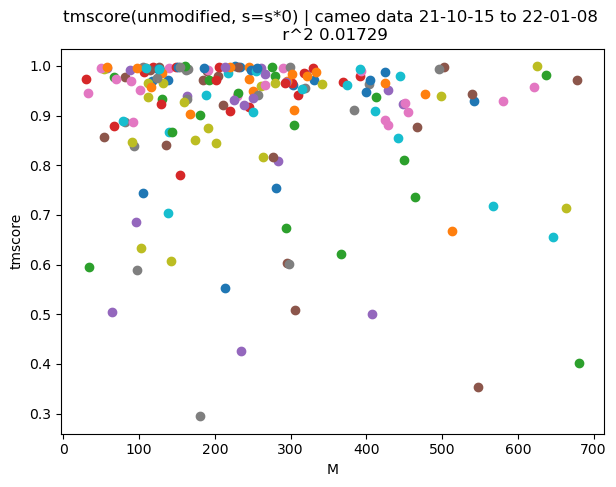

In [28]:
plt.rcParams['figure.figsize'] = [7, 5]
for stat in ['folded_size','effn', 'compactness','seqlen','M']:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            plt.scatter(cameo_dict[protein][stat], cameo_dict[protein]['tmscore'])
            x.append(cameo_dict[protein][stat])
            y.append(cameo_dict[protein]['tmscore'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    plt.title('tmscore(unmodified, s=s*0) | cameo data 21-10-15 to 22-01-08 \n r^2 {:.4}'.format(r_value**2))
    plt.xlabel(stat)
    plt.ylabel('tmscore')
    plt.show()

In [10]:
i=0
for protein in cameo_dict.keys():
    if cameo_dict[protein]['tmscore']>0.99:
        print(i, protein, cameo_dict[protein]['tmscore'])
        i = i + 1

0 7tav_B 0.9971
1 7bcz_A 0.9979
2 7vnb_A 0.9975
3 7dvn_A 0.9963
4 7dmf_A 0.9908
5 7plb_B 0.9962
6 7b28_F 0.9942
7 7ool_A 0.9954
8 7kuw_A 0.9957
9 7ar0_B 0.9978
10 7plq_B 0.9913
11 7e3z_A 0.995
12 7da9_A 0.9908
13 7mu9_A 0.9974
14 7e0m_A 0.9938
15 7dcm_A 0.9967
16 7kos_A 0.9978
17 7b29_A 0.9916
18 7nl4_A 0.9991
19 7dck_A 0.9909
20 7s6g_A 0.9989
21 7l6y_A 0.9985
22 7r84_A 0.9946
23 7f0h_A 0.9992
24 7ksp_A 0.9974
25 7p3b_B 0.9975
26 7s13_C 0.9934
27 7dut_A 0.9977
28 7dms_A 0.9928
29 7bhy_A 0.995
30 7o62_B 0.9973
31 7dko_A 0.9985
32 7q03_A 0.9952
33 7dfe_A 0.9927
34 7lvz_D 0.9931
35 7b7t_A 0.9995
36 7lxc_A 0.9952
37 7eqx_C 0.997
38 7ee3_C 0.9968
39 7re4_A 0.9962
40 7l6j_A 0.9986
41 7kqv_D 0.9935
42 7nx0_E 0.9939
43 7mpz_A 0.9989


In [11]:
# check all pdbs in no mod prediction is in modded prediction
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH):
    if not os.path.isfile(CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + pdb_file):
        print('failed '+pdb_file)

failed hmmstat.txt
failed FORWARD_from_hmmfile.txt
failed MSV_from_hmmfile.txt
failed NSEQ_from_hmmfile.txt
failed EFFN_from_hmmfile.txt
failed VITERBI_from_hmmfile.txt


In [12]:
# check all pdbs in modded prediction is in no mod prediciton
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP):
    if not os.path.isfile(CAMEO_PREDICTION_PATH + pdb_file):
        print('failed '+pdb_file)

In [13]:
# check hmmstat file that each prepended protein is the same as the given name
with open(CAMEO_PREDICTION_PATH + "hmmstat.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    if not parsed[0] == parsed[2][0:6]:
        print(parsed[0],parsed[2][0:6])

In [14]:
# check every fasta is a amino acid chain
# --- Not possible as these downloaded files do not contain that infomation. ---

In [15]:
# Check that the sequence at the top of each uniref... alignment file is the same sequence in the fasta file that was run.



In [16]:

# Is there a relationship between the pair rep and resulting tm score? maybe I could count number of times certain residues pop up?



In [17]:

# do analysis again for relaxed / unrelaxed
# --- nope. just focus on unrelaxed ---

In [18]:
# is there a relationship to physical width?

# yes

In [19]:
# check all proteins in cameo_dict matches with the proteins in sachin's alignment dir
sachin_alignment_proteins = ['6tf4_A','6wmk_A','6wqc_A','6xqj_A','6z01_A','7ab3_E','7amc_A','7ar0_B','7atr_A','7au7_A','7awk_A','7b0d_A','7b1k_B','7b1w_F','7b26_C','7b28_F','7b29_A','7b2a_A','7b2o_A','7b3a_A','7b4q_A','7b7t_A','7bbz_A','7bcb_B','7bcj_A','7bcz_A','7bew_A','7bhy_A','7bny_B','7cjs_B','7da9_A','7dah_E','7dck_A','7dcm_A','7dfe_A','7djy_A','7dk9_A','7dkk_A','7dko_A','7dmf_A','7dms_A','7dnm_B','7dnu_A','7don_B','7dq9_A','7dqg_A','7dru_C','7dsu_B','7dtp_A','7dut_A','7duv_A','7dvn_A','7e0m_A','7e2v_A','7e37_A','7e3z_A','7ee3_C','7eea_A','7ef6_A','7eft_B','7eqx_A','7eqx_C','7esx_A','7et8_A','7ezg_A','7f0h_A','7f17_B','7f6e_B','7f8a_A','7fbh_A','7fbp_B','7fe3_A','7fh3_A','7fip_A','7kdx_B','7kgc_A','7kik_A','7kiu_A','7kos_A','7kqv_D','7ksp_A','7kua_A','7kuw_A','7kzh_A','7l19_C','7l6j_A','7l6y_A','7lbu_A','7lc5_A','7lew_B','7ljh_A','7lnu_B','7ls0_B','7lvz_D','7lxc_A','7m0q_B','7m4m_A','7m4n_A','7mfi_A','7mfw_B','7mpz_A','7mqy_A','7mrk_D','7mro_A','7mrq_A','7mrs_B','7msj_A','7mu9_A','7ndr_A','7nf9_A','7nl4_A','7nmb_A','7nwz_D','7nx0_B','7nx0_E','7ny6_A','7o49_F','7o62_B','7obm_A','7ofn_A','7og0_B','7ool_A','7ouq_A','7p1b_C','7p1v_A','7p3b_B','7p3t_B','7p82_C','7pbk_A','7pkx_A','7plb_B','7plq_B','7poh_B','7ppp_A','7pq7_A','7pqf_A','7prd_A','7q03_A','7q1b_A','7q47_A','7r84_A','7rbw_A','7rds_A','7rdt_A','7re4_A','7re6_A','7rg7_A','7rrm_C','7rwk_A','7s02_C','7s13_C','7s13_L','7s6g_A','7s94_C','7sf6_A','7sh3_A','7siq_A','7sir_A','7spo_C','7spp_C','7swh_A','7swk_B','7sy9_A','7t24_A','7t5f_B','7t71_A','7t8o_B','7t9w_B','7tav_B','7tbs_A','7tcb_B','7v1v_A','7v5y_B','7v6p_A','7vdy_A','7vmu_A','7vnb_A','7vpf_A','7w83_A','7wbr_A']
for p in cameo_dict.keys():
    if p not in sachin_alignment_proteins:
        print(p)
for p in sachin_alignment_proteins:
    if p not in list(cameo_dict.keys()):
        print(p)

In [20]:
# appendix

In [21]:
maxtm = 0.99
print('REMOVE TMSCORE>', maxtm)
list_stats_r2 = {}
for stat in stats:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            if not cameo_dict[protein]['tmscore']>maxtm: # here is the changed code to remove tmscore>0.9
                x.append(cameo_dict[protein][stat])
                y.append(cameo_dict[protein]['tmscore'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    list_stats_r2[stat] = r_value**2

for w in sorted(list_stats_r2, key=list_stats_r2.get, reverse=True):
    print(w, list_stats_r2[w])

REMOVE TMSCORE> 0.99
folded_size 0.12587907803237608
effn 0.07327045564918226
compactness 0.028888168009375857
Strand 0.015788369702036738
seqlen 0.005846016072653629
M 0.0051572497001472276
MSV1 0.004406164975885226
Isolatedbetabridgeresidue 0.003654083141373936
Alphahelix412 0.0035064350402062867
Pihelix 0.002656312539166452
FORWARD1 0.0016091172158062938
VITERBI1 0.0011387598746922234
relent 0.0010706771619725056
Turn 0.0009168982916058357
prelE 0.0007672789353201905
n 0.0005901384767837584
info 0.0005694577073477938
Bend 0.0002307509560600729
MSV2 0.0001907232651661609
VITERBI2 0.0001907232651661609
FORWARD2 0.0001907232651661609
helix310 0.00012662290902482293
compkl 3.9878108658098524e-05


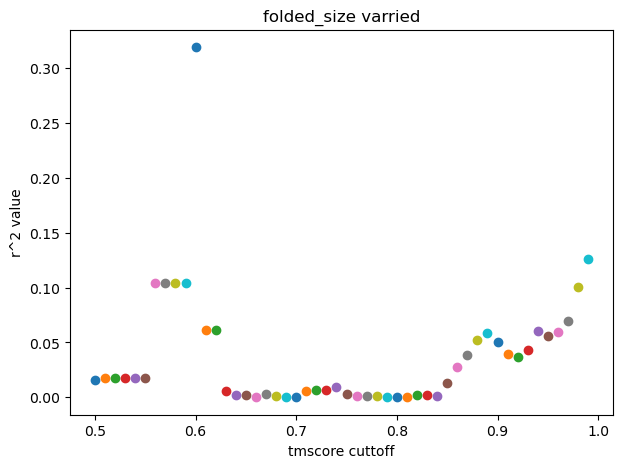

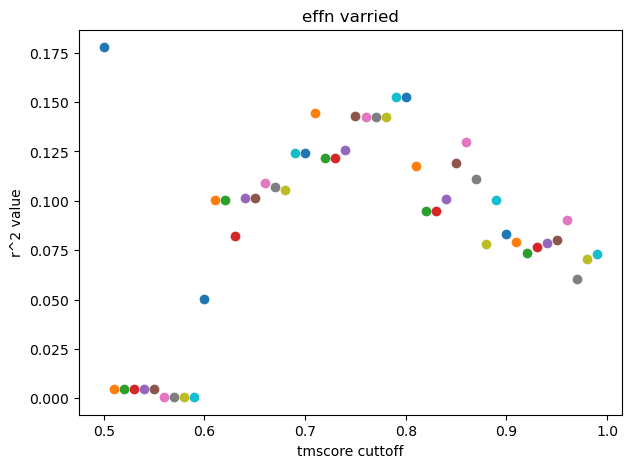

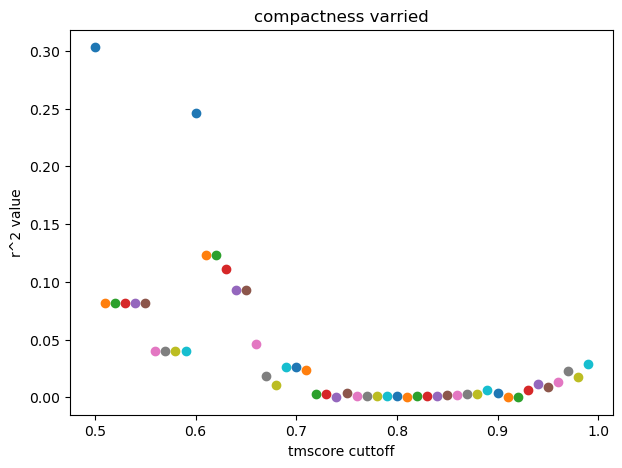

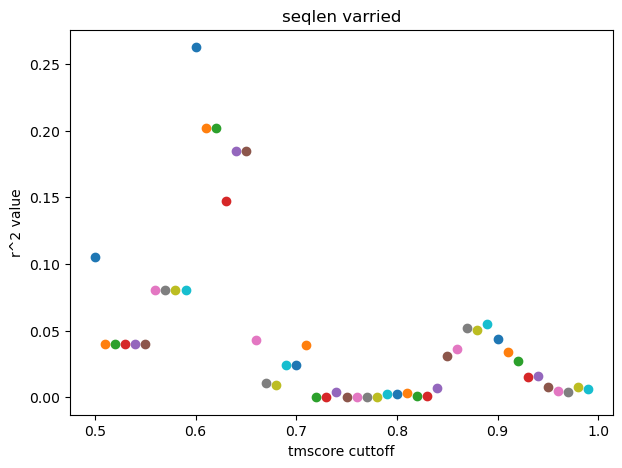

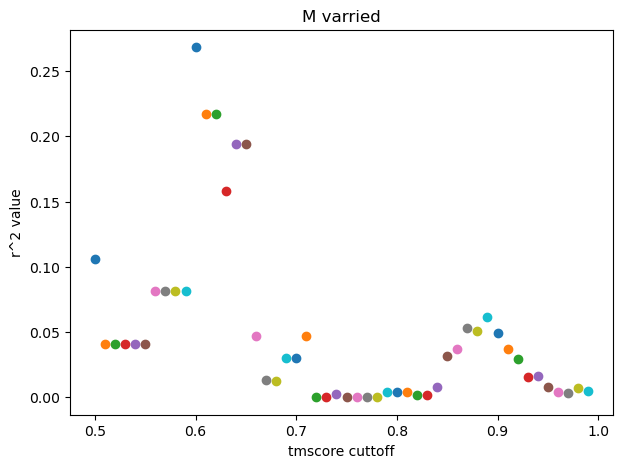

In [22]:
for stat in ['folded_size','effn', 'compactness','seqlen','M']:
    for maxscore in range(50,100):
        maxscore = maxscore*0.01
        x=[]
        y=[]
        for protein in cameo_dict.keys():
            if not cameo_dict[protein]['tmscore']>maxscore:
                x.append(cameo_dict[protein][stat])
                y.append(cameo_dict[protein]['tmscore'])
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        plt.scatter(maxscore,r_value**2)
        plt.title(stat + ' varried')
        plt.xlabel('tmscore cuttoff')
        plt.ylabel('r^2 value')
    plt.show()
